In [1]:
import pandas as pd
import numpy as np
# 함수 파일 import
import import_ipynb
from function_file import *
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
data=pd.read_csv(r"C:\Users\USER\Desktop\비만 예측 REMASTER\data\sampled_data.csv")

importing Jupyter notebook from function_file.ipynb


In [2]:
# 분류할 때 만들었던 특성 'fat' drop
data=data.drop('fat', axis=1)

In [3]:
# 여성만 따로 뽑아서 진행
data=data[data['sex']==2]

# (1). 타겟변수 분포 확인

c:\Users\USER\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='DW_WBT_pFT', ylabel='Density'>

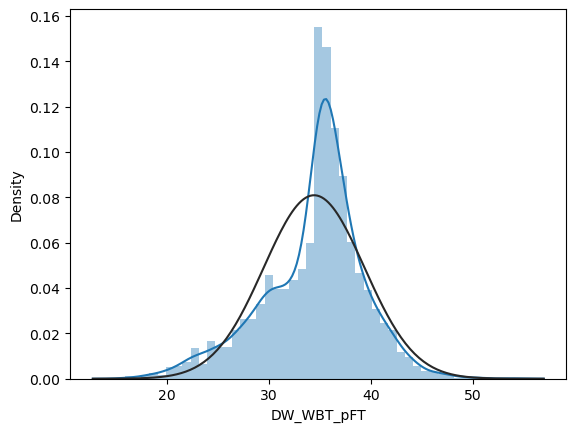

In [4]:
import seaborn as sns
from scipy import stats
from scipy.stats import norm

# distplot : 연속형 데이터의 분포를 보여주는 함수
# fit = norm -> "이 데이터가 정규분포를 따를때의 모습을 보여줌"
# => 정규분포하는지 아닌지 판단 
sns.distplot(data['DW_WBT_pFT'],fit = norm)

((array([-3.44217424, -3.19450614, -3.05732553, ...,  3.05732553,
          3.19450614,  3.44217424]),
  array([15.8453585 , 16.48878477, 17.77954104, ..., 50.05088224,
         50.67885843, 53.79194459])),
 (4.856295072794541, 34.408088690692054, 0.9836092191638699))

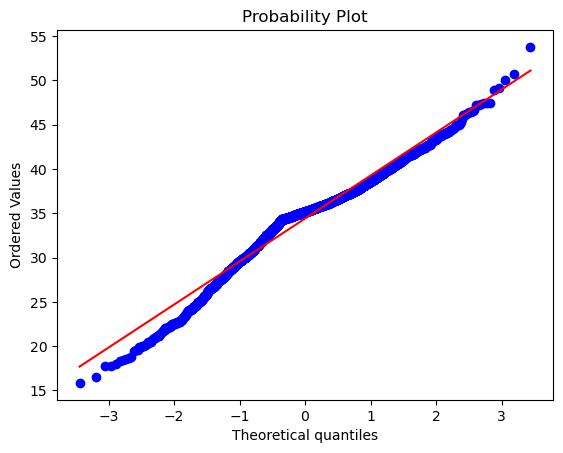

In [5]:
stats.probplot(data['DW_WBT_pFT'], plot=plt)

-> 정규화는 필요 없다고 판단

# (2) 특성 분류 (숫자형, 명목형)
-    '5. feature_filterling.ipynb' 에서 만든 특성 list import

In [6]:
import pickle

# 특성 리스트
with open('total_list.pkl', 'rb') as f:
    total_list = pickle.load(f)

for i in total_list:
    print(i)

continuous_columns
['DW_WBT_BMD', 'N_INTK', 'N_EN', 'HE_wc', 'age', 'HE_wt', 'N_WATER', 'N_FAT', 'DW_WBT_pFT', 'N_CHO', 'BP8', 'HE_ht', 'N_PROT']
category_columns
['BO3_05', 'BO3_01', 'DI1_2', 'BO3_12', 'DK9_dg', 'BO3_07', 'BO2_1', 'sex', 'BO3_04', 'BO1_3', 'BO1_1', 'DI1_dg', 'BO3_09', 'BO3_03', 'BO3_02', 'fat', 'N_DIET']


In [7]:
continuous_columns= total_list[1]
# 타겟변수는 연속형에서 제외
continuous_columns.remove('DW_WBT_pFT')
category_columns=total_list[3]
category_columns.remove('fat')

# (3) 왜도 검사 및 로그화

In [8]:
from scipy.stats import skew 
skewness = data[continuous_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# 왜도 0.5이상을 높다고 판단
high_skewness = skewness[abs(skewness) > 0.75]
skew_feat = high_skewness.index
print(high_skewness)

N_WATER    1.966934
N_FAT      1.943136
N_INTK     1.689906
N_PROT     1.447490
N_EN       1.094939
N_CHO      1.005991
HE_wt      0.940625
dtype: float64


In [9]:
from scipy.special import boxcox1p
lam = 0.15 # 0에 가까울 수록 로그 변환에 가까움, 1~ 제곱근 변환, 2는 자연로그변환
for i in skew_feat:
    data[i] = boxcox1p(data[i], lam)

In [10]:
from scipy.stats import skew 
skewness = data[continuous_columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# 왜도 0.5이상을 높다고 판단
high_skewness = skewness[abs(skewness) > 0.75]
skew_feat = high_skewness.index
print(high_skewness)

Series([], dtype: float64)


# (4) Modeling

-     1. 카테고리형 변수 원핫 인코딩

In [11]:
# category_columns 원핫인코딩
one_hot_list=category_columns
for i in one_hot_list:
    data[i] = data[i].astype(str)

In [12]:
# 원핫인코딩 적용한 데이터 프레임
encoded_data=pd.get_dummies(data[one_hot_list])

-     2. 연속형 변수 min_max_scaling 

In [13]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaler 객체 생성
scaler = MinMaxScaler()

# 선택한 컬럼들에 Min-Max Scaling 적용
data[continuous_columns] = scaler.fit_transform(data[continuous_columns])

In [14]:
# 원핫인코딩한 데이터프레임, 연속형특성 데이터프레임, 타겟변수 데이터프레임 병합
data=pd.concat((encoded_data, data[continuous_columns], data['DW_WBT_pFT']), axis=1)

-     3. 모델링 

In [15]:
X = data.drop(['DW_WBT_pFT','DW_WBT_BMD'], axis=1)
y = data['DW_WBT_pFT']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

CV Fold 1 - MAE: 2.9947, RMSE: 3.8815, MSE: 15.0660
CV Fold 2 - MAE: 2.9026, RMSE: 3.7634, MSE: 14.1632
CV Fold 3 - MAE: 3.2009, RMSE: 4.1570, MSE: 17.2810
CV Fold 4 - MAE: 2.7124, RMSE: 3.5785, MSE: 12.8055
CV Fold 5 - MAE: 2.9617, RMSE: 3.8087, MSE: 14.5059
MAE 평균: 2.9544763612578193
RMSE 평균: 3.8378159111635903
MSE 평균: 14.764322244206658
MSE 표준편차: 1.4621741385672817
['HE_wc', 'HE_wt', 'HE_ht', 'BO2_1_2.0', 'BO1_3_8.0', 'BO1_1_2.0', 'BO3_02_0.0', 'BO2_1_3.0', 'N_DIET_1.0', 'BO3_02_1.0', 'BO3_12_1.0', 'age', 'BO3_01_1.0', 'N_CHO', 'BO3_04_1.0', 'BO3_04_0.0', 'N_WATER', 'BO3_07_1.0', 'BO3_12_0.0', 'BO1_3_2.0', 'N_FAT', 'BO3_03_1.0', 'BO3_05_1.0', 'BO3_07_0.0', 'BO3_03_0.0', 'N_INTK', 'N_EN', 'BP8', 'N_PROT', 'BO1_1_1.0']


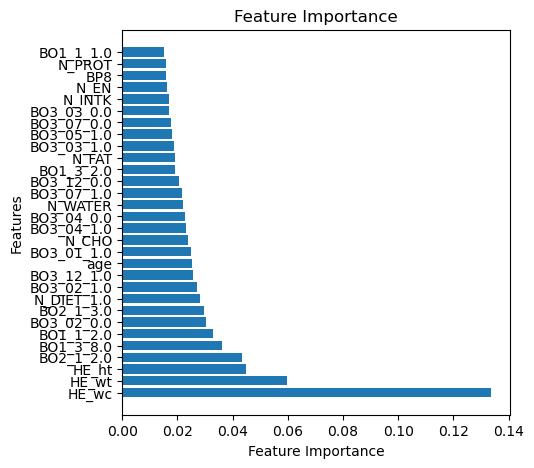

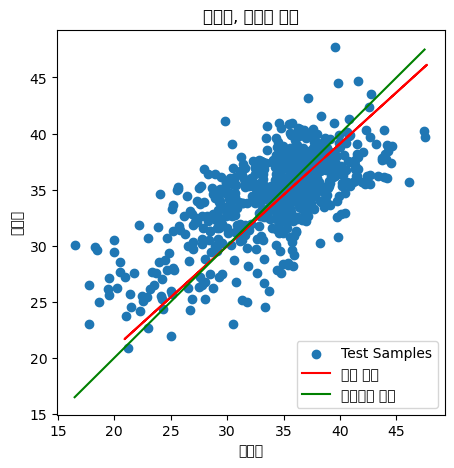

In [17]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# XGBoost 모델
model_XGBoost = xgb.XGBRegressor(max_depth=3, n_estimators=600, learning_rate=0.1)
model_XGBoost.fit(X_train, y_train)
model_val(model_XGBoost, X_train, y_train)
feature_importance(model_XGBoost, X_train, 30)
visualize_model_predictions(model_XGBoost, X_test, y_test)